<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/AMPL_HPO_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install AMPL packages

In [2]:
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

# ! wget -c https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh 
# ! chmod +x Miniconda3-py37_4.9.2-Linux-x86_64.sh
# ! time bash Miniconda3-py37_4.9.2-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

--2021-03-11 00:16:00--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   128MB/s    in 3.7s    

2021-03-11 00:16:04 (135 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7=py37_0
    - anaconda-pr

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
! time conda install -c conda-forge -y mordred bravado molvs

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    bravado-core-5.17.0        |     pyh9f0ad1d_0          48 KB  conda-forge
    jsonref-0.2                |             py_0          11 KB  conda-forge
    molvs-0.1.1                |             py_0          25 KB  conda-forge
    monotonic-1.5              |             py_0           9 KB  conda-forge
    mordred-1.2.0              |             py_1         124 KB  conda-forge
    simplejson-3.17.2          |   py37h8f5063

In [ ]:
pwd

'/content'

In [4]:
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

--2021-03-11 00:27:30--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.07K  --.-KB/s    in 0s      

2021-03-11 00:27:30 (79.3 MB/s) - ‘install_AMPL_GPU_test.sh’ saved [1100/1100]



In [5]:
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

Cloning into 'AMPL'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 1784 (delta 197), reused 164 (delta 128), pack-reused 1520
Receiving objects: 100% (1784/1784), 9.62 MiB | 12.25 MiB/s, done.
Resolving deltas: 100% (1018/1018), done.
Branch 'pkg_upgrade' set up to track remote branch 'pkg_upgrade' from 'origin'.
Switched to a new branch 'pkg_upgrade'
patching file /content/github/AMPL/atomsci/ddm/pipeline/transformations.py
patching file /content/github/AMPL/atomsci/ddm/__init__.py
running build
running build_py
creating /content/github/AMPL.build/ampl/lib
creating /content/github/AMPL.build/ampl/lib/atomsci
copying atomsci/__init__.py -> /content/github/AMPL.build/ampl/lib/atomsci
creating /content/github/AMPL.build/ampl/lib/atomsci/ddm
copying atomsci/ddm/__init__.py -> /content/github/AMPL.build/ampl/lib/atomsci/ddm
creating /content/github/AMPL.build/ampl/lib/atomsci/ddm/pi

In [ ]:
# import sys
# sys.path.append('/content/AMPL/atomsci')
# if '/content/AMPL/lib/python3.7/site-packages' not in sys.path:
#     sys.path.insert(1, '/content/AMPL/lib/python3.7/site-packages')

In [13]:
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/H1_std.csv

--2021-03-11 00:48:25--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/H1_std.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136759 (134K) [text/plain]
Saving to: ‘H1_std.csv’

H1_std.csv          100%[===================>] 133.55K  --.-KB/s    in 0.02s   

2021-03-11 00:48:26 (8.64 MB/s) - ‘H1_std.csv’ saved [136759/136759]



In [6]:
!pip install hyperopt

     |████████████████████████████████| 972kB 9.1MB/s 


### Load packages and dataset

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [16]:
h1 = pd.read_csv("H1_std.csv")

In [17]:
h1

,rdkit_smiles,compound_id,NofA,pKi_mean,pKi_std
0,C(#Cc1c2c(nc3ccccc13)CCCCC2)CCN1CCCCC1,CHEMBL66660,1,4.803188,0.471982
1,C(#Cc1cccc(CN2CCOCC2)c1)CCN1CCCCC1,CHEMBL237087,1,5.000000,0.181920
2,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,CHEMBL43064,1,8.064392,0.163978
3,C/C=C/C(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,CHEMBL3357041,1,6.815309,0.095668
4,C1=C(CCN2CCc3ccccc3C2)CCc2ccccc21,CHEMBL3970994,2,5.841272,0.001272
...,...,...,...,...,...
1353,c1cnc(N2CCN(CCCc3nc4ccccc4s3)CC2)nc1,CHEMBL3289656,2,6.138337,0.001660
1354,c1cnc2c(N3CCN(CCCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)...,CHEMBL3893197,1,7.799971,0.408169
1355,c1cnc2c(N3CCN(CCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)c...,CHEMBL3921827,1,7.100015,0.408169
1356,c1cnc2c(N3CCN(CCc4ccc(OCCCN5CCCCCC5)cc4)CC3)cc...,CHEMBL3947980,1,7.700057,0.408169


### Split the dataset

In [19]:
train_file = "H1_std.csv"
response_col = "pKi_mean"
compound_id = "compound_id"
smiles_col = "rdkit_smiles"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "split"
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-03-11 01:23:36,979 Splitting data by scaffold


number of features: 1024


2021-03-11 01:23:37,925 Dataset split table saved to /H1_std_train_valid_test_scaffold_4758a5d9-81c0-418c-bbc4-899f5dd800e7.csv


### Train an initial model

In [31]:
listing = glob.glob(os.path.join("/", f"H1_std_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "pKi_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [32]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-03-11 01:32:44,639 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:32:48,658 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8735438f-bef7-4fb3-b95f-6b0941773f88/model_metadata.json
2021-03-11 01:32:49,071 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8735438f-bef7-4fb3-b95f-6b0941773f88/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_8735438f-bef7-4fb3-b95f-6b0941773f88.tar.gz


In [33]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.442


### Grid search
#### Tunable parameters for Random Forest models
- rf_estimators: number of estimators to use in random forest models
- rf_max_depth: the maximum depth of a decision tree in the random forest
- rf_max_features: max number of features to split random forest nodes

In [34]:
param_choice = [16,32,64,128]

rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in param_choice:
    for rf_depth in param_choice:
        for rf_feature in param_choice:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

number of features: 1024


2021-03-11 01:33:00,990 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:33:01,817 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/73487f45-3dce-41d3-8fca-c8d6be577f21/model_metadata.json
2021-03-11 01:33:01,830 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/73487f45-3dce-41d3-8fca-c8d6be577f21/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_73487f45-3dce-41d3-8fca-c8d6be577f21.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.376068174208787
number of features: 1024


2021-03-11 01:33:07,340 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:33:08,172 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e77abbe4-9f77-46b5-8e11-689cb324f3bb/model_metadata.json
2021-03-11 01:33:08,185 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e77abbe4-9f77-46b5-8e11-689cb324f3bb/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_e77abbe4-9f77-46b5-8e11-689cb324f3bb.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3804458796434247
number of features: 1024


2021-03-11 01:33:13,692 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:33:14,524 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3dd889b8-fc7b-4a21-a164-2fca4b77f121/model_metadata.json
2021-03-11 01:33:14,538 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3dd889b8-fc7b-4a21-a164-2fca4b77f121/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_3dd889b8-fc7b-4a21-a164-2fca4b77f121.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.43434674525035666
number of features: 1024


2021-03-11 01:33:19,998 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:33:20,927 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e1824107-ea57-40c7-8503-1a1c5b733645/model_metadata.json
2021-03-11 01:33:20,940 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e1824107-ea57-40c7-8503-1a1c5b733645/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_e1824107-ea57-40c7-8503-1a1c5b733645.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.42383404945141423
number of features: 1024


2021-03-11 01:33:26,431 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:33:27,277 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ba0deb0d-f07c-444f-a7b9-647275e74725/model_metadata.json
2021-03-11 01:33:27,295 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ba0deb0d-f07c-444f-a7b9-647275e74725/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_ba0deb0d-f07c-444f-a7b9-647275e74725.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.34845222863137026
number of features: 1024


2021-03-11 01:33:32,833 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:33:33,675 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/70fe3271-a9fe-483e-a6af-c0e4d1d6d938/model_metadata.json
2021-03-11 01:33:33,693 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/70fe3271-a9fe-483e-a6af-c0e4d1d6d938/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_70fe3271-a9fe-483e-a6af-c0e4d1d6d938.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.3857357047617428
number of features: 1024


2021-03-11 01:33:39,210 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:33:40,048 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ecfe7c34-9172-4c6c-a9ac-1a4a1f7c408d/model_metadata.json
2021-03-11 01:33:40,066 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ecfe7c34-9172-4c6c-a9ac-1a4a1f7c408d/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_ecfe7c34-9172-4c6c-a9ac-1a4a1f7c408d.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.3796372570073062
number of features: 1024


2021-03-11 01:33:45,584 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:33:46,511 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0208bf43-0835-4f87-be01-c17db631af1f/model_metadata.json
2021-03-11 01:33:46,529 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0208bf43-0835-4f87-be01-c17db631af1f/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_0208bf43-0835-4f87-be01-c17db631af1f.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.4394878374764889
number of features: 1024


2021-03-11 01:33:51,992 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.056 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.


2021-03-11 01:33:52,825 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/05021dab-2540-460a-a403-9f41dce1c860/model_metadata.json
2021-03-11 01:33:52,843 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/05021dab-2540-460a-a403-9f41dce1c860/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_05021dab-2540-460a-a403-9f41dce1c860.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.3603300908043272
number of features: 1024


2021-03-11 01:33:58,300 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:33:59,132 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b0c1c1e3-4550-4c02-b46d-f5d4927af058/model_metadata.json
2021-03-11 01:33:59,154 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b0c1c1e3-4550-4c02-b46d-f5d4927af058/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_b0c1c1e3-4550-4c02-b46d-f5d4927af058.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.45227881440092244
number of features: 1024


2021-03-11 01:34:04,580 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:34:05,411 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/54844e29-8099-4113-be8d-7be08cc32a6d/model_metadata.json
2021-03-11 01:34:05,430 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/54844e29-8099-4113-be8d-7be08cc32a6d/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_54844e29-8099-4113-be8d-7be08cc32a6d.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4054952050084889
number of features: 1024


2021-03-11 01:34:10,942 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.055 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:34:11,888 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/72330a2c-1d8d-4592-92a1-6988c3ca80f3/model_metadata.json
2021-03-11 01:34:11,906 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/72330a2c-1d8d-4592-92a1-6988c3ca80f3/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_72330a2c-1d8d-4592-92a1-6988c3ca80f3.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.45821637571438134
number of features: 1024


2021-03-11 01:34:17,468 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:34:18,309 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/76bf795d-8bf8-4519-9acf-15dd63495b81/model_metadata.json
2021-03-11 01:34:18,327 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/76bf795d-8bf8-4519-9acf-15dd63495b81/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_76bf795d-8bf8-4519-9acf-15dd63495b81.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.36397809680410864
number of features: 1024


2021-03-11 01:34:23,812 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:34:24,646 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/afcfee14-d378-4b8a-9471-6c72e9c07a55/model_metadata.json
2021-03-11 01:34:24,664 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/afcfee14-d378-4b8a-9471-6c72e9c07a55/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_afcfee14-d378-4b8a-9471-6c72e9c07a55.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.33349596608966736
number of features: 1024


2021-03-11 01:34:30,207 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:34:31,045 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9d82e62d-5e28-4fa8-82de-bac6324bd685/model_metadata.json
2021-03-11 01:34:31,063 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9d82e62d-5e28-4fa8-82de-bac6324bd685/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_9d82e62d-5e28-4fa8-82de-bac6324bd685.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.43862719822542773
number of features: 1024


2021-03-11 01:34:36,555 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:34:37,492 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/20de654f-aa1d-4579-914a-91a2080764da/model_metadata.json
2021-03-11 01:34:37,511 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/20de654f-aa1d-4579-914a-91a2080764da/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_20de654f-aa1d-4579-914a-91a2080764da.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.3774824306879938
number of features: 1024


2021-03-11 01:34:42,962 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:34:43,809 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/31c0620a-e04d-4bb2-9297-315fb9eab991/model_metadata.json
2021-03-11 01:34:43,829 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/31c0620a-e04d-4bb2-9297-315fb9eab991/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_31c0620a-e04d-4bb2-9297-315fb9eab991.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.362403132238172
number of features: 1024


2021-03-11 01:34:49,316 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:34:50,252 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/33cc23eb-7c0d-4521-a5c2-13165bcfbbff/model_metadata.json
2021-03-11 01:34:50,273 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/33cc23eb-7c0d-4521-a5c2-13165bcfbbff/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_33cc23eb-7c0d-4521-a5c2-13165bcfbbff.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.389758899653876
number of features: 1024


2021-03-11 01:34:55,777 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.057 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:34:56,767 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b67f2fad-68cc-4d77-bf71-bb9a999164c8/model_metadata.json
2021-03-11 01:34:56,789 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b67f2fad-68cc-4d77-bf71-bb9a999164c8/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_b67f2fad-68cc-4d77-bf71-bb9a999164c8.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.4314030143635388
number of features: 1024


2021-03-11 01:35:02,275 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:35:03,324 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3146b48f-85aa-4d6d-8353-dcbb588d51a2/model_metadata.json
2021-03-11 01:35:03,347 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3146b48f-85aa-4d6d-8353-dcbb588d51a2/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_3146b48f-85aa-4d6d-8353-dcbb588d51a2.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.46672480435920216
number of features: 1024


2021-03-11 01:35:08,845 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-03-11 01:35:09,812 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/32f6f6ad-cb3d-4116-b918-5e01961a89f1/model_metadata.json
2021-03-11 01:35:09,843 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/32f6f6ad-cb3d-4116-b918-5e01961a89f1/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_32f6f6ad-cb3d-4116-b918-5e01961a89f1.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.43464914479738737
number of features: 1024


2021-03-11 01:35:15,338 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:35:16,301 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e91a8a57-bb30-4964-832a-c3d67297c312/model_metadata.json
2021-03-11 01:35:16,332 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e91a8a57-bb30-4964-832a-c3d67297c312/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_e91a8a57-bb30-4964-832a-c3d67297c312.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4492782019457422
number of features: 1024


2021-03-11 01:35:21,848 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:35:22,811 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/23565c6c-49fa-4d43-bac1-9003f7075123/model_metadata.json
2021-03-11 01:35:22,842 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/23565c6c-49fa-4d43-bac1-9003f7075123/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_23565c6c-49fa-4d43-bac1-9003f7075123.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.41831969678457404
number of features: 1024


2021-03-11 01:35:28,505 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:35:29,575 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7d26e02a-c75a-4bbc-b089-9aa9cc6a2196/model_metadata.json
2021-03-11 01:35:29,605 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7d26e02a-c75a-4bbc-b089-9aa9cc6a2196/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_7d26e02a-c75a-4bbc-b089-9aa9cc6a2196.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.43031172643879934
number of features: 1024


2021-03-11 01:35:35,198 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.058 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:35:36,177 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/683adc8d-afc4-4f66-b9c7-8ae276f318f8/model_metadata.json
2021-03-11 01:35:36,209 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/683adc8d-afc4-4f66-b9c7-8ae276f318f8/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_683adc8d-afc4-4f66-b9c7-8ae276f318f8.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.4330343073296673
number of features: 1024


2021-03-11 01:35:41,749 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:35:42,711 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8f981d2d-1cc3-433e-ac9b-1e5b51f37ddc/model_metadata.json
2021-03-11 01:35:42,744 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8f981d2d-1cc3-433e-ac9b-1e5b51f37ddc/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_8f981d2d-1cc3-433e-ac9b-1e5b51f37ddc.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.4360902927726047
number of features: 1024


2021-03-11 01:35:48,220 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.055 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:35:49,194 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f7585025-29ad-4dd6-bb28-f0820b5479a7/model_metadata.json
2021-03-11 01:35:49,225 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f7585025-29ad-4dd6-bb28-f0820b5479a7/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_f7585025-29ad-4dd6-bb28-f0820b5479a7.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.43676766073393314
number of features: 1024


2021-03-11 01:35:54,728 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:35:55,789 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/59a58360-d807-421e-ab6e-f87c4f543d50/model_metadata.json
2021-03-11 01:35:55,820 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/59a58360-d807-421e-ab6e-f87c4f543d50/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_59a58360-d807-421e-ab6e-f87c4f543d50.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.44976752877441106
number of features: 1024


2021-03-11 01:36:01,338 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:36:02,301 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2cdd0040-dd30-48f4-b6dc-e91b5c0605d4/model_metadata.json
2021-03-11 01:36:02,332 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2cdd0040-dd30-48f4-b6dc-e91b5c0605d4/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_2cdd0040-dd30-48f4-b6dc-e91b5c0605d4.tar.gz
rf_estimators: 32, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.43583580662614874
number of features: 1024


2021-03-11 01:36:07,806 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:36:08,766 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a37078f9-c4f4-43d3-a2ab-ef4d30927d4e/model_metadata.json
2021-03-11 01:36:08,798 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a37078f9-c4f4-43d3-a2ab-ef4d30927d4e/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_a37078f9-c4f4-43d3-a2ab-ef4d30927d4e.tar.gz
rf_estimators: 32, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.41089241003477506
number of features: 1024


2021-03-11 01:36:14,259 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:36:15,320 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2980e460-cf04-416e-8cae-c50de4e6333d/model_metadata.json
2021-03-11 01:36:15,351 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2980e460-cf04-416e-8cae-c50de4e6333d/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_2980e460-cf04-416e-8cae-c50de4e6333d.tar.gz
rf_estimators: 32, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.45975224731800224
number of features: 1024


2021-03-11 01:36:20,859 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:36:21,926 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c88fdbcc-906d-44b3-9ad3-8381fbcb0390/model_metadata.json
2021-03-11 01:36:21,957 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c88fdbcc-906d-44b3-9ad3-8381fbcb0390/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_c88fdbcc-906d-44b3-9ad3-8381fbcb0390.tar.gz
rf_estimators: 32, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4450806170739252
number of features: 1024


2021-03-11 01:36:27,457 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.057 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:36:28,461 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1cbf3eb3-2740-41e1-847b-e548ca9c8d13/model_metadata.json
2021-03-11 01:36:28,497 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1cbf3eb3-2740-41e1-847b-e548ca9c8d13/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_1cbf3eb3-2740-41e1-847b-e548ca9c8d13.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3644394616964388
number of features: 1024


2021-03-11 01:36:34,047 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-03-11 01:36:35,138 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7c60173d-f0a4-4153-ba5b-84c963a22f34/model_metadata.json
2021-03-11 01:36:35,174 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7c60173d-f0a4-4153-ba5b-84c963a22f34/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_7c60173d-f0a4-4153-ba5b-84c963a22f34.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3954182759846966
number of features: 1024


2021-03-11 01:36:40,650 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:36:41,841 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/44e92506-f806-4423-8069-cfd62536de62/model_metadata.json
2021-03-11 01:36:41,878 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/44e92506-f806-4423-8069-cfd62536de62/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_44e92506-f806-4423-8069-cfd62536de62.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.4278398849724647
number of features: 1024


2021-03-11 01:36:47,391 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:36:48,698 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/69f5dfdb-9424-4056-9e2c-4c47d8166f6c/model_metadata.json
2021-03-11 01:36:48,737 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/69f5dfdb-9424-4056-9e2c-4c47d8166f6c/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_69f5dfdb-9424-4056-9e2c-4c47d8166f6c.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.43666956017500447
number of features: 1024


2021-03-11 01:36:54,328 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:36:55,441 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4b628091-be26-4493-bba9-f1ea6916be0f/model_metadata.json
2021-03-11 01:36:55,497 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4b628091-be26-4493-bba9-f1ea6916be0f/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_4b628091-be26-4493-bba9-f1ea6916be0f.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.4209864859745366
number of features: 1024


2021-03-11 01:37:01,008 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:37:02,133 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/014881b9-0dcc-4701-a5d2-353a42d72dc1/model_metadata.json
2021-03-11 01:37:02,194 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/014881b9-0dcc-4701-a5d2-353a42d72dc1/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_014881b9-0dcc-4701-a5d2-353a42d72dc1.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4413542265515975
number of features: 1024


2021-03-11 01:37:07,701 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:37:08,905 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5ccd3cf8-5b0d-4f55-8c87-b7d4bbfea10b/model_metadata.json
2021-03-11 01:37:08,960 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5ccd3cf8-5b0d-4f55-8c87-b7d4bbfea10b/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_5ccd3cf8-5b0d-4f55-8c87-b7d4bbfea10b.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.4835145382659669
number of features: 1024


2021-03-11 01:37:14,457 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:37:15,868 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/75cd7ddb-9fcd-486d-9c58-521213053095/model_metadata.json
2021-03-11 01:37:15,924 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/75cd7ddb-9fcd-486d-9c58-521213053095/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_75cd7ddb-9fcd-486d-9c58-521213053095.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.45513134941265787
number of features: 1024


2021-03-11 01:37:21,398 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:37:22,521 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b99dad56-00a1-4bc3-8ce4-ab77dfb57f51/model_metadata.json
2021-03-11 01:37:22,590 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b99dad56-00a1-4bc3-8ce4-ab77dfb57f51/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_b99dad56-00a1-4bc3-8ce4-ab77dfb57f51.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.39661337144392517
number of features: 1024


2021-03-11 01:37:28,116 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:37:29,337 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/936cee45-9fdc-4b59-aeff-5d01038b224a/model_metadata.json
2021-03-11 01:37:29,396 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/936cee45-9fdc-4b59-aeff-5d01038b224a/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_936cee45-9fdc-4b59-aeff-5d01038b224a.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.44601668750824275
number of features: 1024


2021-03-11 01:37:34,915 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:37:36,139 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ce2667fc-637e-4db7-bb06-ded1b593b11e/model_metadata.json
2021-03-11 01:37:36,206 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ce2667fc-637e-4db7-bb06-ded1b593b11e/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_ce2667fc-637e-4db7-bb06-ded1b593b11e.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.41638746656656345
number of features: 1024


2021-03-11 01:37:41,713 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-03-11 01:37:43,136 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/22f79377-b5c5-4249-867a-bbbf5eab8749/model_metadata.json
2021-03-11 01:37:43,193 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/22f79377-b5c5-4249-867a-bbbf5eab8749/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_22f79377-b5c5-4249-867a-bbbf5eab8749.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.4236287966209078
number of features: 1024


2021-03-11 01:37:48,686 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:37:49,809 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/070de28c-5375-4fbf-ae22-b312ef385ec9/model_metadata.json
2021-03-11 01:37:49,868 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/070de28c-5375-4fbf-ae22-b312ef385ec9/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_070de28c-5375-4fbf-ae22-b312ef385ec9.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.4068867550233587
number of features: 1024


2021-03-11 01:37:55,366 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:37:56,485 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/02c5c1b8-ef46-4f84-8d23-75971f816eda/model_metadata.json
2021-03-11 01:37:56,543 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/02c5c1b8-ef46-4f84-8d23-75971f816eda/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_02c5c1b8-ef46-4f84-8d23-75971f816eda.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.41178460655814586
number of features: 1024


2021-03-11 01:38:02,032 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:38:03,255 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5c0625d0-85ec-426c-96df-aed7d53cc9c0/model_metadata.json
2021-03-11 01:38:03,314 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5c0625d0-85ec-426c-96df-aed7d53cc9c0/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_5c0625d0-85ec-426c-96df-aed7d53cc9c0.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.43144037381190725
number of features: 1024


2021-03-11 01:38:08,828 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:38:10,254 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2a8df618-45d9-4b7a-acb4-0a4641a4046c/model_metadata.json
2021-03-11 01:38:10,310 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2a8df618-45d9-4b7a-acb4-0a4641a4046c/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_2a8df618-45d9-4b7a-acb4-0a4641a4046c.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.44510521121694857
number of features: 1024


2021-03-11 01:38:15,860 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:38:17,133 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0fbe234c-8cfc-42d8-8160-b21139ed0782/model_metadata.json
2021-03-11 01:38:17,198 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0fbe234c-8cfc-42d8-8160-b21139ed0782/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_0fbe234c-8cfc-42d8-8160-b21139ed0782.tar.gz
rf_estimators: 128, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.37368949174610455
number of features: 1024


2021-03-11 01:38:22,740 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:38:24,117 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3372b677-0666-4adc-83e1-746edf246944/model_metadata.json
2021-03-11 01:38:24,185 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3372b677-0666-4adc-83e1-746edf246944/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_3372b677-0666-4adc-83e1-746edf246944.tar.gz
rf_estimators: 128, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.4005204046981796
number of features: 1024


2021-03-11 01:38:29,721 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:38:31,197 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ee9b5162-a96d-4e92-8ee4-c95e280a9e37/model_metadata.json
2021-03-11 01:38:31,268 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ee9b5162-a96d-4e92-8ee4-c95e280a9e37/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_ee9b5162-a96d-4e92-8ee4-c95e280a9e37.tar.gz
rf_estimators: 128, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.4460101409105154
number of features: 1024


2021-03-11 01:38:36,771 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:38:38,547 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/aad23cec-fbe8-4f76-9bd3-930cdd00c419/model_metadata.json
2021-03-11 01:38:38,621 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/aad23cec-fbe8-4f76-9bd3-930cdd00c419/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_aad23cec-fbe8-4f76-9bd3-930cdd00c419.tar.gz
rf_estimators: 128, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.4519347213158277
number of features: 1024


2021-03-11 01:38:44,104 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:38:45,524 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e3731d01-8da3-40b1-a18a-5bbd1c210664/model_metadata.json
2021-03-11 01:38:45,630 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e3731d01-8da3-40b1-a18a-5bbd1c210664/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_e3731d01-8da3-40b1-a18a-5bbd1c210664.tar.gz
rf_estimators: 128, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.423313042599617
number of features: 1024


2021-03-11 01:38:51,104 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.055 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:38:52,643 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bb2eb246-de20-446d-9231-960ef443f250/model_metadata.json
2021-03-11 01:38:52,752 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bb2eb246-de20-446d-9231-960ef443f250/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_bb2eb246-de20-446d-9231-960ef443f250.tar.gz
rf_estimators: 128, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.446165130211445
number of features: 1024


2021-03-11 01:38:58,218 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:38:59,957 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/65e25dd4-cdee-4056-afd3-394122e64ef0/model_metadata.json
2021-03-11 01:39:00,062 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/65e25dd4-cdee-4056-afd3-394122e64ef0/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_65e25dd4-cdee-4056-afd3-394122e64ef0.tar.gz
rf_estimators: 128, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.4510028684523142
number of features: 1024


2021-03-11 01:39:05,520 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.055 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:39:07,558 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5f33b196-7aa8-40e3-b9b6-ecd828462d0a/model_metadata.json
2021-03-11 01:39:07,661 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5f33b196-7aa8-40e3-b9b6-ecd828462d0a/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_5f33b196-7aa8-40e3-b9b6-ecd828462d0a.tar.gz
rf_estimators: 128, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.47581366477807285
number of features: 1024


2021-03-11 01:39:13,154 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.


2021-03-11 01:39:14,603 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0ec4cb05-74a0-4077-ac16-6c15e27a5be2/model_metadata.json
2021-03-11 01:39:14,718 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0ec4cb05-74a0-4077-ac16-6c15e27a5be2/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_0ec4cb05-74a0-4077-ac16-6c15e27a5be2.tar.gz
rf_estimators: 128, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.4336672236439355
number of features: 1024


2021-03-11 01:39:20,198 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:39:21,840 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8324ba19-2db4-4367-854d-37199542eb18/model_metadata.json
2021-03-11 01:39:21,949 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8324ba19-2db4-4367-854d-37199542eb18/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_8324ba19-2db4-4367-854d-37199542eb18.tar.gz
rf_estimators: 128, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.4390007657611582
number of features: 1024


2021-03-11 01:39:27,445 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.069 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:39:29,210 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b99acf4a-b1a0-4793-9432-54b8f107e09d/model_metadata.json
2021-03-11 01:39:29,320 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b99acf4a-b1a0-4793-9432-54b8f107e09d/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_b99acf4a-b1a0-4793-9432-54b8f107e09d.tar.gz
rf_estimators: 128, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.44158492360217927
number of features: 1024


2021-03-11 01:39:34,845 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:39:36,872 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2db7c875-51e6-4e14-845a-97c47689bd43/model_metadata.json
2021-03-11 01:39:36,983 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2db7c875-51e6-4e14-845a-97c47689bd43/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_2db7c875-51e6-4e14-845a-97c47689bd43.tar.gz
rf_estimators: 128, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.4708845328503929
number of features: 1024


2021-03-11 01:39:42,485 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:39:43,908 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/327b1bf6-7b1d-4734-9d73-8579a7f21dc7/model_metadata.json
2021-03-11 01:39:44,018 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/327b1bf6-7b1d-4734-9d73-8579a7f21dc7/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_327b1bf6-7b1d-4734-9d73-8579a7f21dc7.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.41602781191381655
number of features: 1024


2021-03-11 01:39:49,589 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.056 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:39:51,132 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ac7ce796-7c5d-43b1-b80b-d17442b1cfd6/model_metadata.json
2021-03-11 01:39:51,242 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ac7ce796-7c5d-43b1-b80b-d17442b1cfd6/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_ac7ce796-7c5d-43b1-b80b-d17442b1cfd6.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.43448385058847294
number of features: 1024


2021-03-11 01:39:56,709 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:39:58,441 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/db0e8f0f-0ab5-47cb-88f2-daec60469f1a/model_metadata.json
2021-03-11 01:39:58,550 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/db0e8f0f-0ab5-47cb-88f2-daec60469f1a/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_db0e8f0f-0ab5-47cb-88f2-daec60469f1a.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.4520777148703231
number of features: 1024


2021-03-11 01:40:04,066 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:40:06,090 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3047ceee-5e24-4a68-a150-fec2b4769451/model_metadata.json
2021-03-11 01:40:06,196 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3047ceee-5e24-4a68-a150-fec2b4769451/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_3047ceee-5e24-4a68-a150-fec2b4769451.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.45208534872574513


In [35]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
38,64,32,64,0.483515
55,128,32,128,0.475814
59,128,64,128,0.470885
19,32,16,128,0.466725
30,32,128,64,0.459752
...,...,...,...,...
12,16,128,16,0.363978
16,32,16,16,0.362403
8,16,64,16,0.360330
4,16,32,16,0.348452


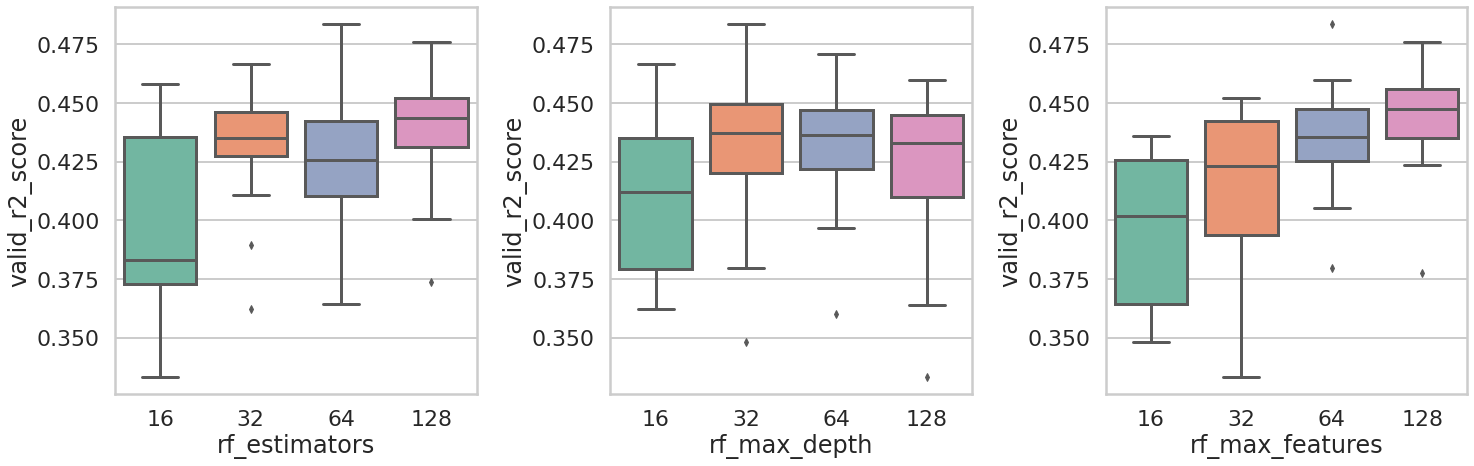

In [36]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

### Random search

In [37]:
rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []

num_trials = 50

for i in range(num_trials):
    params["rf_estimators"] = np.random.randint(8,256)
    params["rf_max_depth"] = np.random.randint(8,256)
    params["rf_max_features"] = np.random.randint(8,256)
    rfe_list.append(params["rf_estimators"])
    rfd_list.append(params["rf_max_depth"])
    rff_list.append(params["rf_max_features"])
    tp = parse.wrapper(params)
    pl = mp.ModelPipeline(tp)
    pl.train_model()
    pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = pred_data.get_prediction_results()
    valid_r2 = pred_results['r2_score']
    valid_r2_list.append(valid_r2)
    print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

number of features: 1024


2021-03-11 01:40:52,955 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.057 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:40:54,129 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b1e699c4-09bb-415c-ac98-e58431bc4981/model_metadata.json
2021-03-11 01:40:54,158 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b1e699c4-09bb-415c-ac98-e58431bc4981/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_b1e699c4-09bb-415c-ac98-e58431bc4981.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4511414380760346
number of features: 1024


2021-03-11 01:40:59,713 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:41:02,180 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8f60850f-635a-41fe-9d89-e1dc6d54ade7/model_metadata.json
2021-03-11 01:41:02,392 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8f60850f-635a-41fe-9d89-e1dc6d54ade7/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_8f60850f-635a-41fe-9d89-e1dc6d54ade7.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4530653037460841
number of features: 1024


2021-03-11 01:41:07,887 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:41:10,622 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/efc1afe1-b22f-4f60-b973-4eeaac9eb536/model_metadata.json
2021-03-11 01:41:10,775 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/efc1afe1-b22f-4f60-b973-4eeaac9eb536/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_efc1afe1-b22f-4f60-b973-4eeaac9eb536.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.45980659634475474
number of features: 1024


2021-03-11 01:41:16,239 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-03-11 01:41:17,784 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e4a45a10-fcee-471d-bf70-2b92cf2d6c96/model_metadata.json
2021-03-11 01:41:17,844 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e4a45a10-fcee-471d-bf70-2b92cf2d6c96/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_e4a45a10-fcee-471d-bf70-2b92cf2d6c96.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4644869700436911
number of features: 1024


2021-03-11 01:41:23,350 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.057 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:41:24,541 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e86c003c-1607-4315-bae9-281ef5cd315a/model_metadata.json
2021-03-11 01:41:24,580 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e86c003c-1607-4315-bae9-281ef5cd315a/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_e86c003c-1607-4315-bae9-281ef5cd315a.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.44850337544269825
number of features: 1024


2021-03-11 01:41:30,116 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:41:34,261 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/daaf0268-dfad-4e4f-abd6-518569c518a9/model_metadata.json
2021-03-11 01:41:34,455 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/daaf0268-dfad-4e4f-abd6-518569c518a9/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_daaf0268-dfad-4e4f-abd6-518569c518a9.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.47399932932289135
number of features: 1024


2021-03-11 01:41:40,030 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:41:43,235 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f0135423-705b-4cab-8cb7-81b1576a189e/model_metadata.json
2021-03-11 01:41:43,373 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f0135423-705b-4cab-8cb7-81b1576a189e/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_f0135423-705b-4cab-8cb7-81b1576a189e.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4499585660191181
number of features: 1024


2021-03-11 01:41:48,888 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:41:50,347 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8961e38f-7061-4230-8c6b-c7b2c0740656/model_metadata.json
2021-03-11 01:41:50,423 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8961e38f-7061-4230-8c6b-c7b2c0740656/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_8961e38f-7061-4230-8c6b-c7b2c0740656.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4613329713579093
number of features: 1024


2021-03-11 01:41:55,982 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:41:56,845 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/74b2576c-17b5-45e1-b125-e855a682f8e0/model_metadata.json
2021-03-11 01:41:56,857 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/74b2576c-17b5-45e1-b125-e855a682f8e0/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_74b2576c-17b5-45e1-b125-e855a682f8e0.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.2497576520046484
number of features: 1024


2021-03-11 01:42:02,446 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:42:04,229 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2b58cf82-c7f2-4ad9-8258-5d19b3ebdca6/model_metadata.json
2021-03-11 01:42:04,310 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2b58cf82-c7f2-4ad9-8258-5d19b3ebdca6/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_2b58cf82-c7f2-4ad9-8258-5d19b3ebdca6.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4702789789550772
number of features: 1024


2021-03-11 01:42:09,832 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:42:14,285 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/96ef4192-82b3-419f-badb-d6500fab1085/model_metadata.json
2021-03-11 01:42:14,499 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/96ef4192-82b3-419f-badb-d6500fab1085/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_96ef4192-82b3-419f-badb-d6500fab1085.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.44603258162083337
number of features: 1024


2021-03-11 01:42:20,064 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:42:23,875 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/67d951ba-4968-4b9a-8c3c-bb6b7d32b832/model_metadata.json
2021-03-11 01:42:24,056 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/67d951ba-4968-4b9a-8c3c-bb6b7d32b832/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_67d951ba-4968-4b9a-8c3c-bb6b7d32b832.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4552147943503363
number of features: 1024


2021-03-11 01:42:29,678 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.


2021-03-11 01:42:32,083 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/6f672016-c42d-4415-bff6-ffa17839f5f6/model_metadata.json
2021-03-11 01:42:32,208 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/6f672016-c42d-4415-bff6-ffa17839f5f6/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_6f672016-c42d-4415-bff6-ffa17839f5f6.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4488460883063441
number of features: 1024


2021-03-11 01:42:37,976 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.059 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:42:40,057 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4df5a2cc-3a4f-4d52-bc5b-07b7caccc3eb/model_metadata.json
2021-03-11 01:42:40,263 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4df5a2cc-3a4f-4d52-bc5b-07b7caccc3eb/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_4df5a2cc-3a4f-4d52-bc5b-07b7caccc3eb.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.40345043692659366
number of features: 1024


2021-03-11 01:42:45,961 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:42:47,487 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f1071dea-3a67-463e-911f-1dc56c14888b/model_metadata.json
2021-03-11 01:42:47,583 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f1071dea-3a67-463e-911f-1dc56c14888b/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_f1071dea-3a67-463e-911f-1dc56c14888b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.42163265809273476
number of features: 1024


2021-03-11 01:42:53,194 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.056 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-03-11 01:42:55,085 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9dc372d2-9e83-4b14-bc14-dcd071e1a871/model_metadata.json
2021-03-11 01:42:55,258 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9dc372d2-9e83-4b14-bc14-dcd071e1a871/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_9dc372d2-9e83-4b14-bc14-dcd071e1a871.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4315559251583866
number of features: 1024


2021-03-11 01:43:00,968 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:43:04,189 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9cefff2d-a2f0-4237-8f85-274bb0b9c723/model_metadata.json
2021-03-11 01:43:04,378 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9cefff2d-a2f0-4237-8f85-274bb0b9c723/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_9cefff2d-a2f0-4237-8f85-274bb0b9c723.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.47736906187898775
number of features: 1024


2021-03-11 01:43:10,030 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:43:11,558 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bba10b31-1eba-435c-ae75-e7edf84c62d8/model_metadata.json
2021-03-11 01:43:11,608 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/bba10b31-1eba-435c-ae75-e7edf84c62d8/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_bba10b31-1eba-435c-ae75-e7edf84c62d8.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.43560256365109173
number of features: 1024


2021-03-11 01:43:17,185 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:43:18,776 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0d266f75-3461-40bf-bf93-f29c2c7da134/model_metadata.json
2021-03-11 01:43:18,858 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0d266f75-3461-40bf-bf93-f29c2c7da134/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_0d266f75-3461-40bf-bf93-f29c2c7da134.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.45249810956474734
number of features: 1024


2021-03-11 01:43:24,418 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:43:26,756 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9ed9a977-3739-428a-87fd-083b90f16481/model_metadata.json
2021-03-11 01:43:26,953 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9ed9a977-3739-428a-87fd-083b90f16481/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_9ed9a977-3739-428a-87fd-083b90f16481.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.45213495661857783
number of features: 1024


2021-03-11 01:43:32,579 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:43:34,655 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c750318e-6392-4e6c-bac8-a809e8fce7ab/model_metadata.json
2021-03-11 01:43:34,820 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c750318e-6392-4e6c-bac8-a809e8fce7ab/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_c750318e-6392-4e6c-bac8-a809e8fce7ab.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.43456003110178554
number of features: 1024


2021-03-11 01:43:40,427 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:43:42,817 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/271b6a6f-b963-4b57-a701-588dc37ec470/model_metadata.json
2021-03-11 01:43:42,976 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/271b6a6f-b963-4b57-a701-588dc37ec470/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_271b6a6f-b963-4b57-a701-588dc37ec470.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4402917394616548
number of features: 1024


2021-03-11 01:43:48,606 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:43:52,669 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c30cbb81-2c58-40d7-8311-b7f5f0c5f523/model_metadata.json
2021-03-11 01:43:52,867 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c30cbb81-2c58-40d7-8311-b7f5f0c5f523/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_c30cbb81-2c58-40d7-8311-b7f5f0c5f523.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4492675446987763
number of features: 1024


2021-03-11 01:43:58,452 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.055 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:44:00,822 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c1e79b81-5dc1-41f5-b1d5-60f457572c1d/model_metadata.json
2021-03-11 01:44:00,988 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c1e79b81-5dc1-41f5-b1d5-60f457572c1d/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_c1e79b81-5dc1-41f5-b1d5-60f457572c1d.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.46384474565442446
number of features: 1024


2021-03-11 01:44:06,622 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.056 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:44:08,269 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c742ffcc-7697-481f-8fb6-46610223191c/model_metadata.json
2021-03-11 01:44:08,368 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c742ffcc-7697-481f-8fb6-46610223191c/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_c742ffcc-7697-481f-8fb6-46610223191c.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.46241778971348413
number of features: 1024


2021-03-11 01:44:14,168 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:44:16,053 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0a6f4802-8096-4337-8d0f-067ae8a9d539/model_metadata.json
2021-03-11 01:44:16,179 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0a6f4802-8096-4337-8d0f-067ae8a9d539/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_0a6f4802-8096-4337-8d0f-067ae8a9d539.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4519064498362362
number of features: 1024


2021-03-11 01:44:21,879 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:44:22,815 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/46ff45a1-ec85-4798-b4f2-d40256e1f5a7/model_metadata.json
2021-03-11 01:44:22,829 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/46ff45a1-ec85-4798-b4f2-d40256e1f5a7/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_46ff45a1-ec85-4798-b4f2-d40256e1f5a7.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4384544482379459
number of features: 1024


2021-03-11 01:44:28,586 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:44:31,132 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a890c16b-b552-48d3-a97a-e801f4922946/model_metadata.json
2021-03-11 01:44:31,282 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a890c16b-b552-48d3-a97a-e801f4922946/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_a890c16b-b552-48d3-a97a-e801f4922946.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4506590712525327
number of features: 1024


2021-03-11 01:44:36,926 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:44:39,721 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0d9ca22c-dc04-4c8b-beef-bc520719c9af/model_metadata.json
2021-03-11 01:44:39,908 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0d9ca22c-dc04-4c8b-beef-bc520719c9af/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_0d9ca22c-dc04-4c8b-beef-bc520719c9af.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4569601795739413
number of features: 1024


2021-03-11 01:44:45,764 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.062 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:44:48,043 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b1ef2dac-a542-4ded-abfb-e584e835cd66/model_metadata.json
2021-03-11 01:44:48,138 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b1ef2dac-a542-4ded-abfb-e584e835cd66/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_b1ef2dac-a542-4ded-abfb-e584e835cd66.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4450306608560477
number of features: 1024


2021-03-11 01:44:53,905 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:44:56,172 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/38912c53-5d2b-4963-b233-6bf885e77825/model_metadata.json
2021-03-11 01:44:56,292 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/38912c53-5d2b-4963-b233-6bf885e77825/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_38912c53-5d2b-4963-b233-6bf885e77825.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4658265024141889
number of features: 1024


2021-03-11 01:45:01,917 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-03-11 01:45:02,968 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f1c64c9d-4f74-455c-a420-b22fcaf3afa3/model_metadata.json
2021-03-11 01:45:02,988 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f1c64c9d-4f74-455c-a420-b22fcaf3afa3/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_f1c64c9d-4f74-455c-a420-b22fcaf3afa3.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4513996593877643
number of features: 1024


2021-03-11 01:45:08,555 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:45:10,997 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a3de85e6-78d7-4777-ae0d-ddd156e6711f/model_metadata.json
2021-03-11 01:45:11,193 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a3de85e6-78d7-4777-ae0d-ddd156e6711f/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_a3de85e6-78d7-4777-ae0d-ddd156e6711f.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4551837218022239
number of features: 1024


2021-03-11 01:45:16,734 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.


2021-03-11 01:45:18,830 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e987dfd2-740c-49bf-abf7-20225fbdaec0/model_metadata.json
2021-03-11 01:45:18,919 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e987dfd2-740c-49bf-abf7-20225fbdaec0/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_e987dfd2-740c-49bf-abf7-20225fbdaec0.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.45573529505501065
number of features: 1024


2021-03-11 01:45:24,445 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:45:25,798 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e139a269-2cbd-46c0-81c5-a9e6d3af0bf7/model_metadata.json
2021-03-11 01:45:25,853 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e139a269-2cbd-46c0-81c5-a9e6d3af0bf7/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_e139a269-2cbd-46c0-81c5-a9e6d3af0bf7.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4378410600032756
number of features: 1024


2021-03-11 01:45:31,415 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:45:34,008 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/15aec456-0b6f-43c3-94e9-d34c0d519b1d/model_metadata.json
2021-03-11 01:45:34,127 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/15aec456-0b6f-43c3-94e9-d34c0d519b1d/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_15aec456-0b6f-43c3-94e9-d34c0d519b1d.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.45727107705269543
number of features: 1024


2021-03-11 01:45:39,671 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.057 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:45:42,444 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/76d41ee7-266f-4422-aa7a-20e9cfe92163/model_metadata.json
2021-03-11 01:45:42,656 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/76d41ee7-266f-4422-aa7a-20e9cfe92163/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_76d41ee7-266f-4422-aa7a-20e9cfe92163.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4576437145851122
number of features: 1024


2021-03-11 01:45:48,257 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.056 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:45:51,837 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/45050bc3-04b4-4fbe-8057-ef25e05696e4/model_metadata.json
2021-03-11 01:45:52,000 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/45050bc3-04b4-4fbe-8057-ef25e05696e4/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_45050bc3-04b4-4fbe-8057-ef25e05696e4.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.46999401850543243
number of features: 1024


2021-03-11 01:45:57,555 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.055 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:45:59,934 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/acb25575-dbb7-4588-8ac1-9c32cfb5db5b/model_metadata.json
2021-03-11 01:46:00,095 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/acb25575-dbb7-4588-8ac1-9c32cfb5db5b/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_acb25575-dbb7-4588-8ac1-9c32cfb5db5b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.46530243120734205
number of features: 1024


2021-03-11 01:46:05,614 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:46:07,528 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0d1515fb-c454-4330-81f1-8abefca1e8cf/model_metadata.json
2021-03-11 01:46:07,624 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/0d1515fb-c454-4330-81f1-8abefca1e8cf/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_0d1515fb-c454-4330-81f1-8abefca1e8cf.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.45378601135043983
number of features: 1024


2021-03-11 01:46:13,196 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:46:14,137 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b8039b5a-dc11-4d86-ac12-fb2517c93978/model_metadata.json
2021-03-11 01:46:14,152 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b8039b5a-dc11-4d86-ac12-fb2517c93978/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_b8039b5a-dc11-4d86-ac12-fb2517c93978.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4671045184577929
number of features: 1024


2021-03-11 01:46:19,728 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:46:20,786 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4ef51b55-e37c-4a55-863f-16fa8abe96db/model_metadata.json
2021-03-11 01:46:20,809 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4ef51b55-e37c-4a55-863f-16fa8abe96db/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_4ef51b55-e37c-4a55-863f-16fa8abe96db.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4046889353783055
number of features: 1024


2021-03-11 01:46:26,471 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.


2021-03-11 01:46:27,308 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b60c8173-883d-4459-a98f-6f435398b027/model_metadata.json
2021-03-11 01:46:27,321 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b60c8173-883d-4459-a98f-6f435398b027/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_b60c8173-883d-4459-a98f-6f435398b027.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4431767727660595
number of features: 1024


2021-03-11 01:46:32,925 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:46:33,985 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a3297c89-5639-4b86-a426-dbe4216e5947/model_metadata.json
2021-03-11 01:46:34,009 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a3297c89-5639-4b86-a426-dbe4216e5947/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_a3297c89-5639-4b86-a426-dbe4216e5947.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4722631059700393
number of features: 1024


2021-03-11 01:46:39,585 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.053 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:46:40,637 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2a1746ce-e45b-4fce-a42c-ecb8d5deb9b9/model_metadata.json
2021-03-11 01:46:40,661 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2a1746ce-e45b-4fce-a42c-ecb8d5deb9b9/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_2a1746ce-e45b-4fce-a42c-ecb8d5deb9b9.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.49021980103533214
number of features: 1024


2021-03-11 01:46:46,200 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


2021-03-11 01:46:48,384 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/12573f29-b4c1-4940-8535-a0f7183cf1ef/model_metadata.json
2021-03-11 01:46:48,555 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/12573f29-b4c1-4940-8535-a0f7183cf1ef/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_12573f29-b4c1-4940-8535-a0f7183cf1ef.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.45619419293986263
number of features: 1024


2021-03-11 01:46:54,115 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:46:58,007 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/da1817bf-93f9-4039-914c-6289e503ea18/model_metadata.json
2021-03-11 01:46:58,187 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/da1817bf-93f9-4039-914c-6289e503ea18/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_da1817bf-93f9-4039-914c-6289e503ea18.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4784138426502247
number of features: 1024


2021-03-11 01:47:03,786 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.


2021-03-11 01:47:05,314 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8b752948-6d90-4ec4-aa17-56d1ae496256/model_metadata.json
2021-03-11 01:47:05,418 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8b752948-6d90-4ec4-aa17-56d1ae496256/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_8b752948-6d90-4ec4-aa17-56d1ae496256.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4279328249065679
number of features: 1024


2021-03-11 01:47:10,908 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:47:12,719 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c26eca76-735e-4831-a245-efed7cf3b315/model_metadata.json
2021-03-11 01:47:12,855 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c26eca76-735e-4831-a245-efed7cf3b315/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_c26eca76-735e-4831-a245-efed7cf3b315.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4247182633885348
number of features: 1024


2021-03-11 01:47:18,354 Previous dataset split restored


n_cnt [1358.]
y_means [6.59994988]
y_stds [1.29836641]
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


2021-03-11 01:47:19,400 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/af5ddb21-d6e1-4794-aef5-06bcaaa2e3d7/model_metadata.json
2021-03-11 01:47:19,414 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/af5ddb21-d6e1-4794-aef5-06bcaaa2e3d7/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_af5ddb21-d6e1-4794-aef5-06bcaaa2e3d7.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.40166433575984495


In [38]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
44,22,35,252,0.490220
46,218,233,236,0.478414
16,222,211,141,0.477369
5,240,134,247,0.473999
43,23,248,215,0.472263
9,97,200,127,0.470279
37,197,85,235,0.469994
40,11,95,214,0.467105
30,139,115,134,0.465827
38,187,199,88,0.465302


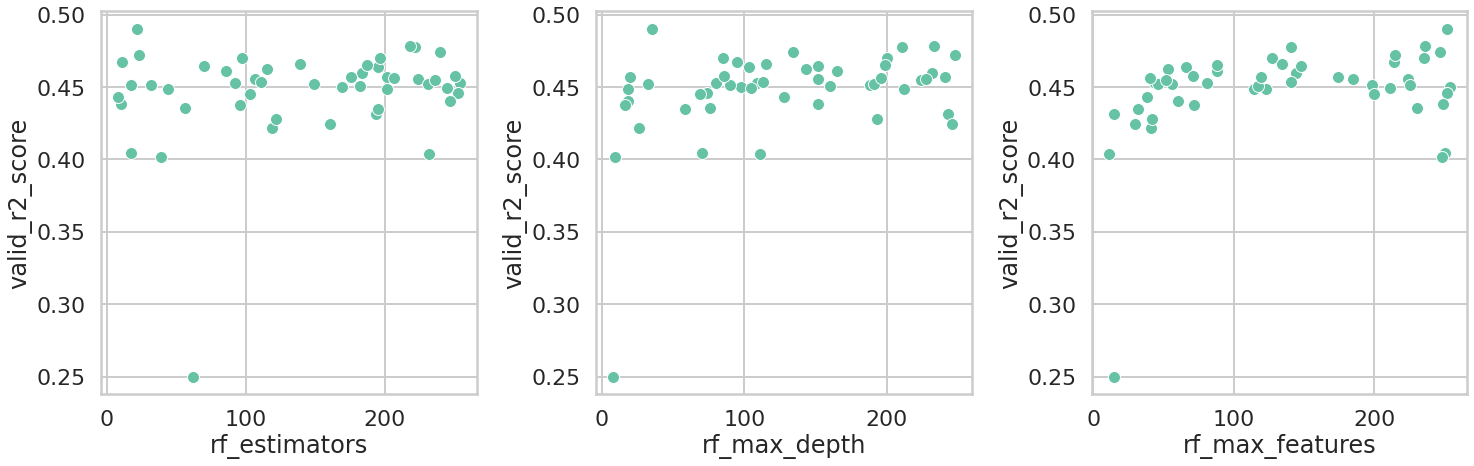

In [39]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

### Bayesian search

In [ ]:
hp.

In [41]:
#define loss function
def lossfn(p):
    params["rf_estimators"] = int(p["rf_estimator"])
    params["rf_max_depth"] = int(p["rf_depth"])
    params["rf_max_features"] = int(p["rf_feature"])
    
    tparam = parse.wrapper(params)
    pl = mp.ModelPipeline(tparam)
    pl.train_model()
    perf_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = perf_data.get_prediction_results()
    r2 = pred_results['r2_score']
    return {'loss': 1-r2, 
            'status': STATUS_OK, 
            'model': tparam.model_tarball_path, 
            'rf_estimator': params["rf_estimators"],
            'rf_depth': params["rf_max_depth"],
            'rf_feature': params["rf_max_features"]}

space = {
    "rf_estimator": hp.uniform("rf_estimator", 8, 256),
    "rf_depth": hp.uniform("rf_depth", 8, 256),
    "rf_feature": hp.uniform("rf_feature", 8, 256)
}

In [42]:
trials = Trials()
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=50, trials=trials)

number of features: 1024
  0%|          | 0/50 [00:05<?, ?it/s, best loss: ?]

2021-03-11 01:51:38,430 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.066 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
  0%|          | 0/50 [00:05<?, ?it/s, best loss: ?]

2021-03-11 01:51:42,634 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/76c93f36-0a45-421e-8887-4575c5c5a38b/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_76c93f36-0a45-421e-8887-4575c5c5a38b.tar.gz
  0%|          | 0/50 [00:10<?, ?it/s, best loss: ?]

2021-03-11 01:51:42,841 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/76c93f36-0a45-421e-8887-4575c5c5a38b/model_metrics.json


number of features: 1024
  2%|▏         | 1/50 [00:15<08:13, 10.07s/it, best loss: 0.5337526173924108]

2021-03-11 01:51:48,510 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.071 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
  2%|▏         | 1/50 [00:15<08:13, 10.07s/it, best loss: 0.5337526173924108]

2021-03-11 01:51:51,350 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8c00eaa1-ee1c-4336-85e5-15f388081da1/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_8c00eaa1-ee1c-4336-85e5-15f388081da1.tar.gz
  2%|▏         | 1/50 [00:18<08:13, 10.07s/it, best loss: 0.5337526173924108]

2021-03-11 01:51:51,473 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/8c00eaa1-ee1c-4336-85e5-15f388081da1/model_metrics.json


number of features: 1024
  4%|▍         | 2/50 [00:23<07:42,  9.64s/it, best loss: 0.5337526173924108]

2021-03-11 01:51:57,094 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.070 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
  4%|▍         | 2/50 [00:24<07:42,  9.64s/it, best loss: 0.5337526173924108]

2021-03-11 01:51:58,921 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/03267e88-bd1a-411d-b70e-341b93d294a5/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_03267e88-bd1a-411d-b70e-341b93d294a5.tar.gz
  4%|▍         | 2/50 [00:26<07:42,  9.64s/it, best loss: 0.5337526173924108]

2021-03-11 01:51:59,035 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/03267e88-bd1a-411d-b70e-341b93d294a5/model_metrics.json


number of features: 1024
  6%|▌         | 3/50 [00:31<07:03,  9.02s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:04,633 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.063 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
  6%|▌         | 3/50 [00:32<07:03,  9.02s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:06,025 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a1895352-1c7b-4e4b-92e0-bd8112b88e5a/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_a1895352-1c7b-4e4b-92e0-bd8112b88e5a.tar.gz
  6%|▌         | 3/50 [00:33<07:03,  9.02s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:06,077 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a1895352-1c7b-4e4b-92e0-bd8112b88e5a/model_metrics.json


number of features: 1024
  8%|▊         | 4/50 [00:38<06:27,  8.42s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:11,637 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.068 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.
  8%|▊         | 4/50 [00:39<06:27,  8.42s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:13,879 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/53fd6d8a-8562-4cf0-b9b0-cdd387e2c7bf/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_53fd6d8a-8562-4cf0-b9b0-cdd387e2c7bf.tar.gz
  8%|▊         | 4/50 [00:41<06:27,  8.42s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:13,992 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/53fd6d8a-8562-4cf0-b9b0-cdd387e2c7bf/model_metrics.json


number of features: 1024
 10%|█         | 5/50 [00:46<06:12,  8.27s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:19,512 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.070 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
 10%|█         | 5/50 [00:46<06:12,  8.27s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:21,991 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d4b40bb3-2d0e-4ff4-a4b2-fbc6f1c59f9b/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_d4b40bb3-2d0e-4ff4-a4b2-fbc6f1c59f9b.tar.gz
 10%|█         | 5/50 [00:49<06:12,  8.27s/it, best loss: 0.5337526173924108]

2021-03-11 01:52:22,171 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d4b40bb3-2d0e-4ff4-a4b2-fbc6f1c59f9b/model_metrics.json


number of features: 1024
 12%|█▏        | 6/50 [00:54<06:02,  8.24s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:27,782 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
 12%|█▏        | 6/50 [00:55<06:02,  8.24s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:29,849 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/61744a40-a504-4e5e-aad8-ec0b9d6877c6/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_61744a40-a504-4e5e-aad8-ec0b9d6877c6.tar.gz
 12%|█▏        | 6/50 [00:57<06:02,  8.24s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:30,029 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/61744a40-a504-4e5e-aad8-ec0b9d6877c6/model_metrics.json


number of features: 1024
 14%|█▍        | 7/50 [01:02<05:49,  8.13s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:35,562 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
 14%|█▍        | 7/50 [01:02<05:49,  8.13s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:38,894 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c3cada21-0b9a-4be2-bfbf-3ebb01a8502b/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_c3cada21-0b9a-4be2-bfbf-3ebb01a8502b.tar.gz
 14%|█▍        | 7/50 [01:06<05:49,  8.13s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:39,060 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/c3cada21-0b9a-4be2-bfbf-3ebb01a8502b/model_metrics.json


number of features: 1024
 16%|█▌        | 8/50 [01:11<05:52,  8.40s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:44,576 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.069 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
 16%|█▌        | 8/50 [01:12<05:52,  8.40s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:46,086 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d9efa057-21e3-4915-803d-9cc58f57eefa/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_d9efa057-21e3-4915-803d-9cc58f57eefa.tar.gz
 16%|█▌        | 8/50 [01:13<05:52,  8.40s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:46,142 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d9efa057-21e3-4915-803d-9cc58f57eefa/model_metrics.json


number of features: 1024
 18%|█▊        | 9/50 [01:18<05:28,  8.00s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:51,708 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.066 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
 18%|█▊        | 9/50 [01:19<05:28,  8.00s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:53,088 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/58c8115c-9d06-465b-8477-6f57d183433e/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_58c8115c-9d06-465b-8477-6f57d183433e.tar.gz
 18%|█▊        | 9/50 [01:20<05:28,  8.00s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:53,125 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/58c8115c-9d06-465b-8477-6f57d183433e/model_metrics.json


number of features: 1024
 20%|██        | 10/50 [01:25<05:07,  7.70s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:58,726 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.062 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
 20%|██        | 10/50 [01:26<05:07,  7.70s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:59,899 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a8f8fd0c-aeca-4725-a71b-ee44b7d18238/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_a8f8fd0c-aeca-4725-a71b-ee44b7d18238.tar.gz
 20%|██        | 10/50 [01:27<05:07,  7.70s/it, best loss: 0.5333491655234396]

2021-03-11 01:52:59,939 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a8f8fd0c-aeca-4725-a71b-ee44b7d18238/model_metrics.json


number of features: 1024
 22%|██▏       | 11/50 [01:32<04:49,  7.43s/it, best loss: 0.5333491655234396]

2021-03-11 01:53:05,495 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.068 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
 22%|██▏       | 11/50 [01:32<04:49,  7.43s/it, best loss: 0.5333491655234396]

2021-03-11 01:53:08,467 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e2c07ead-962b-42af-8036-a8a4f38b3fc3/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_e2c07ead-962b-42af-8036-a8a4f38b3fc3.tar.gz
 22%|██▏       | 11/50 [01:35<04:49,  7.43s/it, best loss: 0.5333491655234396]

2021-03-11 01:53:08,590 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e2c07ead-962b-42af-8036-a8a4f38b3fc3/model_metrics.json


number of features: 1024
 24%|██▍       | 12/50 [01:40<04:56,  7.80s/it, best loss: 0.5333491655234396]

2021-03-11 01:53:14,134 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
 24%|██▍       | 12/50 [01:41<04:56,  7.80s/it, best loss: 0.5333491655234396]

2021-03-11 01:53:16,399 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e540f507-3f1a-4297-bf51-218a0d852df4/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_e540f507-3f1a-4297-bf51-218a0d852df4.tar.gz
 24%|██▍       | 12/50 [01:43<04:56,  7.80s/it, best loss: 0.5333491655234396]

2021-03-11 01:53:16,527 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e540f507-3f1a-4297-bf51-218a0d852df4/model_metrics.json


number of features: 1024
 26%|██▌       | 13/50 [01:48<04:50,  7.84s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:22,090 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.068 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
 26%|██▌       | 13/50 [01:49<04:50,  7.84s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:23,704 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9f307184-7b38-4536-9c81-75a87f6987bd/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_9f307184-7b38-4536-9c81-75a87f6987bd.tar.gz
 26%|██▌       | 13/50 [01:51<04:50,  7.84s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:23,810 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9f307184-7b38-4536-9c81-75a87f6987bd/model_metrics.json


number of features: 1024
 28%|██▊       | 14/50 [01:56<04:36,  7.67s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:29,363 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.065 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
 28%|██▊       | 14/50 [01:56<04:36,  7.67s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:32,053 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7dec5928-a22a-4b22-8adf-4895599fd818/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_7dec5928-a22a-4b22-8adf-4895599fd818.tar.gz
 28%|██▊       | 14/50 [01:59<04:36,  7.67s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:32,235 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/7dec5928-a22a-4b22-8adf-4895599fd818/model_metrics.json


number of features: 1024
 30%|███       | 15/50 [02:04<04:36,  7.90s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:37,860 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.074 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
 30%|███       | 15/50 [02:05<04:36,  7.90s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:40,400 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/94319f7f-9071-4a6d-8b7f-205b58b95068/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_94319f7f-9071-4a6d-8b7f-205b58b95068.tar.gz
 30%|███       | 15/50 [02:07<04:36,  7.90s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:40,553 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/94319f7f-9071-4a6d-8b7f-205b58b95068/model_metrics.json


number of features: 1024
 32%|███▏      | 16/50 [02:12<04:32,  8.03s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:46,121 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 32%|███▏      | 16/50 [02:13<04:32,  8.03s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:49,015 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/82938342-8e54-4346-9cf5-4b41aa5ced89/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_82938342-8e54-4346-9cf5-4b41aa5ced89.tar.gz
 32%|███▏      | 16/50 [02:16<04:32,  8.03s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:49,148 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/82938342-8e54-4346-9cf5-4b41aa5ced89/model_metrics.json


number of features: 1024
 34%|███▍      | 17/50 [02:21<04:30,  8.19s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:54,681 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 34%|███▍      | 17/50 [02:22<04:30,  8.19s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:57,064 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9f65b83e-d747-4e76-8431-23ae5e02545a/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_9f65b83e-d747-4e76-8431-23ae5e02545a.tar.gz
 34%|███▍      | 17/50 [02:24<04:30,  8.19s/it, best loss: 0.5250154952721562]

2021-03-11 01:53:57,240 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9f65b83e-d747-4e76-8431-23ae5e02545a/model_metrics.json


number of features: 1024
 36%|███▌      | 18/50 [02:29<04:21,  8.17s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:02,805 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.064 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.
 36%|███▌      | 18/50 [02:30<04:21,  8.17s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:05,367 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1d05cee4-23a7-438f-9f35-a1ce16c25d39/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_1d05cee4-23a7-438f-9f35-a1ce16c25d39.tar.gz
 36%|███▌      | 18/50 [02:32<04:21,  8.17s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:05,535 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1d05cee4-23a7-438f-9f35-a1ce16c25d39/model_metrics.json


number of features: 1024
 38%|███▊      | 19/50 [02:37<04:14,  8.20s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:11,149 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.058 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
 38%|███▊      | 19/50 [02:38<04:14,  8.20s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:12,576 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/db6c4b78-eda6-4ef6-a706-0c1376f967d9/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_db6c4b78-eda6-4ef6-a706-0c1376f967d9.tar.gz
 38%|███▊      | 19/50 [02:39<04:14,  8.20s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:12,633 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/db6c4b78-eda6-4ef6-a706-0c1376f967d9/model_metrics.json


number of features: 1024
 40%|████      | 20/50 [02:44<03:56,  7.87s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:18,145 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.089 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
 40%|████      | 20/50 [02:45<03:56,  7.87s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:19,664 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/02067bd7-3c81-49b7-8682-88bc1788976f/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_02067bd7-3c81-49b7-8682-88bc1788976f.tar.gz
 40%|████      | 20/50 [02:46<03:56,  7.87s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:19,713 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/02067bd7-3c81-49b7-8682-88bc1788976f/model_metrics.json


number of features: 1024
 42%|████▏     | 21/50 [02:52<03:41,  7.63s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:25,278 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
 42%|████▏     | 21/50 [02:52<03:41,  7.63s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:26,341 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a1c1f078-92c0-4fbd-9f03-772b360d34a2/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_a1c1f078-92c0-4fbd-9f03-772b360d34a2.tar.gz
 42%|████▏     | 21/50 [02:53<03:41,  7.63s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:26,360 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a1c1f078-92c0-4fbd-9f03-772b360d34a2/model_metrics.json


number of features: 1024
 44%|████▍     | 22/50 [02:58<03:25,  7.34s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:31,967 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
 44%|████▍     | 22/50 [02:59<03:25,  7.34s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:33,379 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/56caec81-1e56-45ba-9631-5c008db678a5/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_56caec81-1e56-45ba-9631-5c008db678a5.tar.gz
 44%|████▍     | 22/50 [03:00<03:25,  7.34s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:33,411 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/56caec81-1e56-45ba-9631-5c008db678a5/model_metrics.json


number of features: 1024
 46%|████▌     | 23/50 [03:05<03:15,  7.25s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:39,017 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.068 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.
 46%|████▌     | 23/50 [03:06<03:15,  7.25s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:41,025 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/17cb3785-6f3c-4e6d-adaa-7f42328777fd/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_17cb3785-6f3c-4e6d-adaa-7f42328777fd.tar.gz
 46%|████▌     | 23/50 [03:08<03:15,  7.25s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:41,112 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/17cb3785-6f3c-4e6d-adaa-7f42328777fd/model_metrics.json


number of features: 1024
 48%|████▊     | 24/50 [03:13<03:12,  7.39s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:46,631 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.069 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
 48%|████▊     | 24/50 [03:14<03:12,  7.39s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:48,635 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/febbe06a-5bc5-4263-9a02-959173d2a567/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_febbe06a-5bc5-4263-9a02-959173d2a567.tar.gz
 48%|████▊     | 24/50 [03:15<03:12,  7.39s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:48,723 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/febbe06a-5bc5-4263-9a02-959173d2a567/model_metrics.json


number of features: 1024
 50%|█████     | 25/50 [03:21<03:06,  7.45s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:54,293 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 50%|█████     | 25/50 [03:21<03:06,  7.45s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:56,898 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/68f20c67-981b-4814-bb6b-f31e90d9b167/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_68f20c67-981b-4814-bb6b-f31e90d9b167.tar.gz
 50%|█████     | 25/50 [03:24<03:06,  7.45s/it, best loss: 0.5250154952721562]

2021-03-11 01:54:57,039 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/68f20c67-981b-4814-bb6b-f31e90d9b167/model_metrics.json


number of features: 1024
 52%|█████▏    | 26/50 [03:29<03:05,  7.71s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:02,585 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 52%|█████▏    | 26/50 [03:30<03:05,  7.71s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:04,692 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/32404fda-964e-4be5-837b-564defac765a/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_32404fda-964e-4be5-837b-564defac765a.tar.gz
 52%|█████▏    | 26/50 [03:32<03:05,  7.71s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:04,790 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/32404fda-964e-4be5-837b-564defac765a/model_metrics.json


number of features: 1024
 54%|█████▍    | 27/50 [03:37<02:57,  7.72s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:10,348 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
 54%|█████▍    | 27/50 [03:37<02:57,  7.72s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:12,008 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2ed2d47e-f89f-4c77-9b38-d2ffe938f5c2/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_2ed2d47e-f89f-4c77-9b38-d2ffe938f5c2.tar.gz
 54%|█████▍    | 27/50 [03:39<02:57,  7.72s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:12,076 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/2ed2d47e-f89f-4c77-9b38-d2ffe938f5c2/model_metrics.json


number of features: 1024
 56%|█████▌    | 28/50 [03:44<02:47,  7.59s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:17,676 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.071 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 56%|█████▌    | 28/50 [03:45<02:47,  7.59s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:21,524 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/da411529-0fc2-482e-b7ba-a022793585a1/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_da411529-0fc2-482e-b7ba-a022793585a1.tar.gz
 56%|█████▌    | 28/50 [03:48<02:47,  7.59s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:21,720 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/da411529-0fc2-482e-b7ba-a022793585a1/model_metrics.json


number of features: 1024
 58%|█████▊    | 29/50 [03:54<02:52,  8.21s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:27,289 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.073 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
 58%|█████▊    | 29/50 [03:54<02:52,  8.21s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:29,763 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a48f17ae-ed70-4b82-a1c9-4948c9119e8f/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_a48f17ae-ed70-4b82-a1c9-4948c9119e8f.tar.gz
 58%|█████▊    | 29/50 [03:57<02:52,  8.21s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:29,896 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a48f17ae-ed70-4b82-a1c9-4948c9119e8f/model_metrics.json


number of features: 1024
 60%|██████    | 30/50 [04:02<02:43,  8.20s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:35,417 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
 60%|██████    | 30/50 [04:02<02:43,  8.20s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:36,446 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5b030a1c-e616-4c04-90cb-69dd13125770/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_5b030a1c-e616-4c04-90cb-69dd13125770.tar.gz
 60%|██████    | 30/50 [04:03<02:43,  8.20s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:36,474 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5b030a1c-e616-4c04-90cb-69dd13125770/model_metrics.json


number of features: 1024
 62%|██████▏   | 31/50 [04:08<02:26,  7.71s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:42,078 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 62%|██████▏   | 31/50 [04:09<02:26,  7.71s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:43,244 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e0c72103-d902-4f74-9e1d-435b7ef5039c/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_e0c72103-d902-4f74-9e1d-435b7ef5039c.tar.gz
 62%|██████▏   | 31/50 [04:10<02:26,  7.71s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:43,270 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/e0c72103-d902-4f74-9e1d-435b7ef5039c/model_metrics.json


number of features: 1024
 64%|██████▍   | 32/50 [04:15<02:13,  7.44s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:48,904 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
 64%|██████▍   | 32/50 [04:16<02:13,  7.44s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:53,032 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/13bf9fb4-4d18-40bb-af7f-b9075f8e5d51/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_13bf9fb4-4d18-40bb-af7f-b9075f8e5d51.tar.gz
 64%|██████▍   | 32/50 [04:20<02:13,  7.44s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:53,221 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/13bf9fb4-4d18-40bb-af7f-b9075f8e5d51/model_metrics.json


number of features: 1024
 66%|██████▌   | 33/50 [04:25<02:19,  8.19s/it, best loss: 0.5250154952721562]

2021-03-11 01:55:58,774 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.068 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
 66%|██████▌   | 33/50 [04:26<02:19,  8.19s/it, best loss: 0.5250154952721562]

2021-03-11 01:56:00,434 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a1d5b225-8edf-4c9a-ade1-ca8513b33b0d/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_a1d5b225-8edf-4c9a-ade1-ca8513b33b0d.tar.gz
 66%|██████▌   | 33/50 [04:27<02:19,  8.19s/it, best loss: 0.5250154952721562]

2021-03-11 01:56:00,561 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a1d5b225-8edf-4c9a-ade1-ca8513b33b0d/model_metrics.json


number of features: 1024
 68%|██████▊   | 34/50 [04:32<02:06,  7.94s/it, best loss: 0.5250154952721562]

2021-03-11 01:56:06,113 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.070 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
 68%|██████▊   | 34/50 [04:33<02:06,  7.94s/it, best loss: 0.5250154952721562]

2021-03-11 01:56:07,972 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4eeb1cf3-e614-462c-87fd-79ed09310898/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_4eeb1cf3-e614-462c-87fd-79ed09310898.tar.gz
 68%|██████▊   | 34/50 [04:35<02:06,  7.94s/it, best loss: 0.5250154952721562]

2021-03-11 01:56:08,045 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4eeb1cf3-e614-462c-87fd-79ed09310898/model_metrics.json


number of features: 1024
 70%|███████   | 35/50 [04:40<01:56,  7.80s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:13,692 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
 70%|███████   | 35/50 [04:41<01:56,  7.80s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:15,039 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/36c128ca-2b8b-425a-82e3-8fc94ab5f2d1/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_36c128ca-2b8b-425a-82e3-8fc94ab5f2d1.tar.gz
 70%|███████   | 35/50 [04:42<01:56,  7.80s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:15,109 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/36c128ca-2b8b-425a-82e3-8fc94ab5f2d1/model_metrics.json


number of features: 1024
 72%|███████▏  | 36/50 [04:47<01:46,  7.58s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:20,714 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.104 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
 72%|███████▏  | 36/50 [04:48<01:46,  7.58s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:22,677 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a42c74b0-96af-4841-a1ed-b82987e2cd14/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_a42c74b0-96af-4841-a1ed-b82987e2cd14.tar.gz
 72%|███████▏  | 36/50 [04:50<01:46,  7.58s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:22,784 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a42c74b0-96af-4841-a1ed-b82987e2cd14/model_metrics.json


number of features: 1024
 74%|███████▍  | 37/50 [04:55<01:38,  7.61s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:28,349 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.074 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
 74%|███████▍  | 37/50 [04:55<01:38,  7.61s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:32,641 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9147af50-af69-4a9b-aae9-33092bd297a4/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_9147af50-af69-4a9b-aae9-33092bd297a4.tar.gz
 74%|███████▍  | 37/50 [05:00<01:38,  7.61s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:32,849 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/9147af50-af69-4a9b-aae9-33092bd297a4/model_metrics.json


number of features: 1024
 76%|███████▌  | 38/50 [05:05<01:40,  8.35s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:38,444 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
 76%|███████▌  | 38/50 [05:05<01:40,  8.35s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:39,844 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/60a55eda-97d3-4734-8e01-a6f1eabd7a63/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_60a55eda-97d3-4734-8e01-a6f1eabd7a63.tar.gz
 76%|███████▌  | 38/50 [05:07<01:40,  8.35s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:39,891 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/60a55eda-97d3-4734-8e01-a6f1eabd7a63/model_metrics.json


number of features: 1024
 78%|███████▊  | 39/50 [05:12<01:27,  7.95s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:45,444 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.074 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 78%|███████▊  | 39/50 [05:12<01:27,  7.95s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:47,708 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b7f5e93e-b39f-4608-8e8c-650773ac2c0c/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_b7f5e93e-b39f-4608-8e8c-650773ac2c0c.tar.gz
 78%|███████▊  | 39/50 [05:15<01:27,  7.95s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:47,829 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b7f5e93e-b39f-4608-8e8c-650773ac2c0c/model_metrics.json


number of features: 1024
 80%|████████  | 40/50 [05:20<01:19,  7.95s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:53,487 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 80%|████████  | 40/50 [05:20<01:19,  7.95s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:55,708 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b39b7e26-c22e-4682-977b-e835fa395d1b/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_b39b7e26-c22e-4682-977b-e835fa395d1b.tar.gz
 80%|████████  | 40/50 [05:23<01:19,  7.95s/it, best loss: 0.5240899965622219]

2021-03-11 01:56:55,861 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b39b7e26-c22e-4682-977b-e835fa395d1b/model_metrics.json


number of features: 1024
 82%|████████▏ | 41/50 [05:28<01:11,  7.97s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:01,432 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.068 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 82%|████████▏ | 41/50 [05:28<01:11,  7.97s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:03,405 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/00c1b116-4e6f-45be-83cc-6a5f9e885a72/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_00c1b116-4e6f-45be-83cc-6a5f9e885a72.tar.gz
 82%|████████▏ | 41/50 [05:30<01:11,  7.97s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:03,488 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/00c1b116-4e6f-45be-83cc-6a5f9e885a72/model_metrics.json


number of features: 1024
 84%|████████▍ | 42/50 [05:35<01:02,  7.87s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:09,070 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.078 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
 84%|████████▍ | 42/50 [05:36<01:02,  7.87s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:10,368 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b3c07c2b-c897-4886-b3a0-fa9606f21e5e/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_b3c07c2b-c897-4886-b3a0-fa9606f21e5e.tar.gz
 84%|████████▍ | 42/50 [05:37<01:02,  7.87s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:10,404 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b3c07c2b-c897-4886-b3a0-fa9606f21e5e/model_metrics.json


number of features: 1024
 86%|████████▌ | 43/50 [05:42<00:53,  7.58s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:16,007 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
 86%|████████▌ | 43/50 [05:43<00:53,  7.58s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:17,417 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/341fc8d6-7b81-42f3-9d33-c77bfb327aa7/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_341fc8d6-7b81-42f3-9d33-c77bfb327aa7.tar.gz
 86%|████████▌ | 43/50 [05:44<00:53,  7.58s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:17,471 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/341fc8d6-7b81-42f3-9d33-c77bfb327aa7/model_metrics.json


number of features: 1024
 88%|████████▊ | 44/50 [05:49<00:44,  7.43s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:23,067 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.062 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.028 s
Loading dataset from disk.
 88%|████████▊ | 44/50 [05:50<00:44,  7.43s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:24,690 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/693eb40b-7584-4288-b376-1d00edcbd92e/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_693eb40b-7584-4288-b376-1d00edcbd92e.tar.gz
 88%|████████▊ | 44/50 [05:52<00:44,  7.43s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:24,799 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/693eb40b-7584-4288-b376-1d00edcbd92e/model_metrics.json


number of features: 1024
 90%|█████████ | 45/50 [05:57<00:36,  7.40s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:30,405 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.070 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
 90%|█████████ | 45/50 [05:57<00:36,  7.40s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:32,816 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/349801a4-b08d-402e-ac6c-a363574af232/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_349801a4-b08d-402e-ac6c-a363574af232.tar.gz
 90%|█████████ | 45/50 [06:00<00:36,  7.40s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:32,961 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/349801a4-b08d-402e-ac6c-a363574af232/model_metrics.json


number of features: 1024
 92%|█████████▏| 46/50 [06:05<00:30,  7.63s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:38,511 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
 92%|█████████▏| 46/50 [06:05<00:30,  7.63s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:40,269 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1fece5ba-36c1-4b5c-8eb3-7499b37bc7a2/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_1fece5ba-36c1-4b5c-8eb3-7499b37bc7a2.tar.gz
 92%|█████████▏| 46/50 [06:07<00:30,  7.63s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:40,335 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1fece5ba-36c1-4b5c-8eb3-7499b37bc7a2/model_metrics.json


number of features: 1024
 94%|█████████▍| 47/50 [06:12<00:22,  7.55s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:45,896 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.071 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
 94%|█████████▍| 47/50 [06:13<00:22,  7.55s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:48,478 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/abb6a7a3-e317-4d7a-a362-c86dc5a17117/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_abb6a7a3-e317-4d7a-a362-c86dc5a17117.tar.gz
 94%|█████████▍| 47/50 [06:15<00:22,  7.55s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:48,646 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/abb6a7a3-e317-4d7a-a362-c86dc5a17117/model_metrics.json


number of features: 1024
 96%|█████████▌| 48/50 [06:21<00:15,  7.78s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:54,215 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.091 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
 96%|█████████▌| 48/50 [06:21<00:15,  7.78s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:56,781 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3b29bcb0-4fe0-4400-80af-81683ecf3f57/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_3b29bcb0-4fe0-4400-80af-81683ecf3f57.tar.gz
 96%|█████████▌| 48/50 [06:24<00:15,  7.78s/it, best loss: 0.5240899965622219]

2021-03-11 01:57:56,908 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3b29bcb0-4fe0-4400-80af-81683ecf3f57/model_metrics.json


number of features: 1024
 98%|█████████▊| 49/50 [06:29<00:07,  7.93s/it, best loss: 0.5240899965622219]

2021-03-11 01:58:02,476 Previous dataset split restored


n_cnt
[1358.]
y_means
[6.59994988]
y_stds
[1.29836641]
TIMING: dataset construction took 0.080 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.014 s
Loading dataset from disk.
 98%|█████████▊| 49/50 [06:29<00:07,  7.93s/it, best loss: 0.5240899965622219]

2021-03-11 01:58:04,438 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/94209e64-68d1-48a6-a434-3680fffff953/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_94209e64-68d1-48a6-a434-3680fffff953.tar.gz
 98%|█████████▊| 49/50 [06:31<00:07,  7.93s/it, best loss: 0.5240899965622219]

2021-03-11 01:58:04,546 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/94209e64-68d1-48a6-a434-3680fffff953/model_metrics.json


100%|██████████| 50/50 [06:31<00:00,  7.84s/it, best loss: 0.5240899965622219]


(0.2, 0.6)

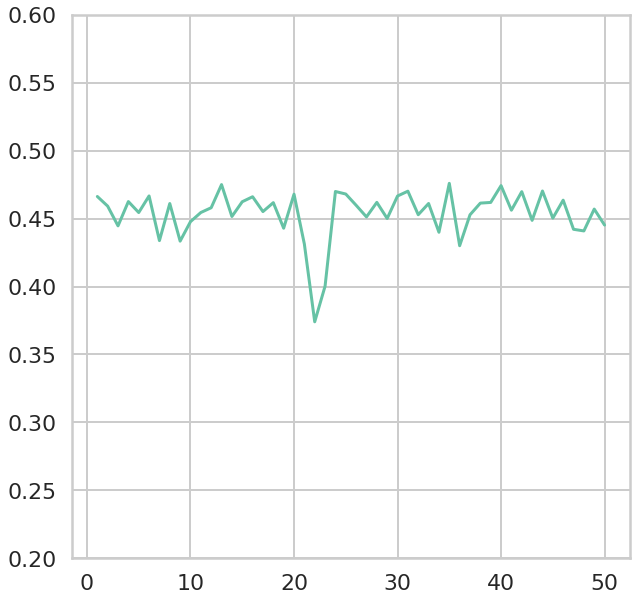

In [43]:
r2_list = [1-trials.trials[i]["result"]["loss"] for i in range(len(trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(trials.trials)+1)), y=r2_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [44]:
rfe_list = [trials.trials[i]["result"]["rf_estimator"] for i in range(len(trials.trials))]
rfd_list = [trials.trials[i]["result"]["rf_depth"] for i in range(len(trials.trials))]
rff_list = [trials.trials[i]["result"]["rf_feature"] for i in range(len(trials.trials))]

In [45]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
34,73,147,226,0.475910
12,144,77,124,0.474985
39,140,28,129,0.474240
43,51,142,148,0.470261
30,8,135,238,0.470130
23,100,93,164,0.469901
41,86,161,220,0.469789
24,100,99,168,0.468042
19,60,255,117,0.467925
5,209,40,70,0.466651
